# ECSE415 - Assignment 2 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Matching using SIFT - Book Reveal

### Find SIFT keypoints in given input images

In [2]:
# Read images to stitch
img_crop = cv2.imread('book_crop.jpg')
img_occ = cv2.imread('book_occlusion.jpg')

img_occ = cv2.cvtColor(img_occ, cv2.COLOR_BGR2RGB)
img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_occ, descriptors_occ = sift_obj.detectAndCompute(img_occ, None)
keypoints_crop, descriptors_crop = sift_obj.detectAndCompute(img_crop, None)



### Match keypoints of reference image to the keypoints of the occluded image using brute-force method

In [3]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors.
matches = bf.match(descriptors_crop,descriptors_occ) # query image, train image


### Sort matching keypoints according to the matching distance

In [4]:
matches = sorted(matches, key = lambda x:x.distance)

### Display top ten matching keypoints

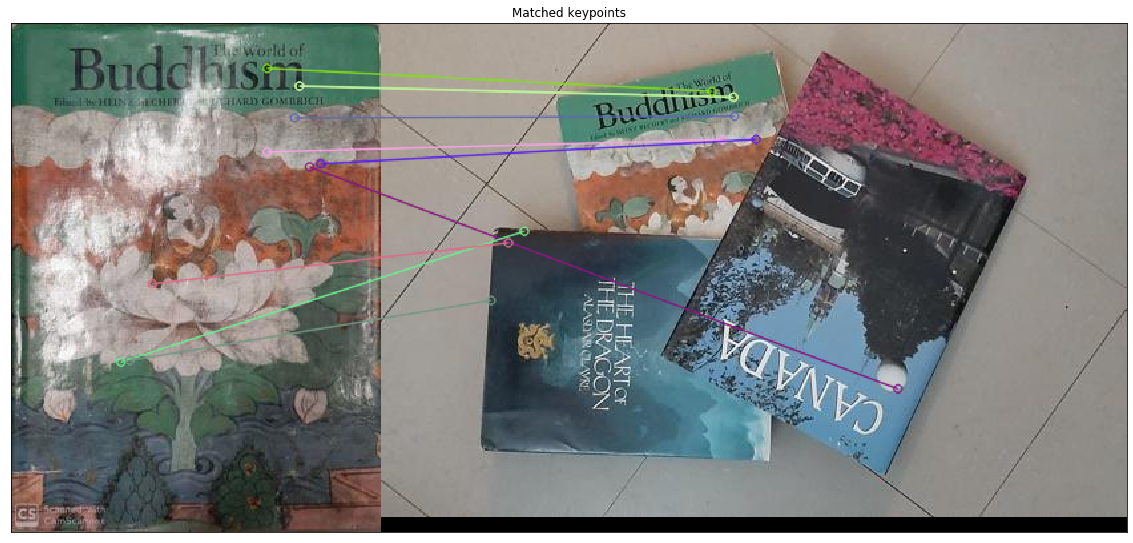

In [5]:
# Draw keypoints 
imgmatch = cv2.drawMatches(img_crop,keypoints_crop,img_occ,keypoints_occ, matches[:10], None, flags=2)


plt.figure(figsize=(20,20))
plt.imshow(imgmatch)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### Compute a homography to align the images using RANSAC method and apply the transformation on the reference image

In [6]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_crop[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_occ[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img_crop, H, (img_crop.shape[1] + 100, img_crop.shape[0]) )

### Paste transformed reference image on the occluded view to generate un- occluded view 

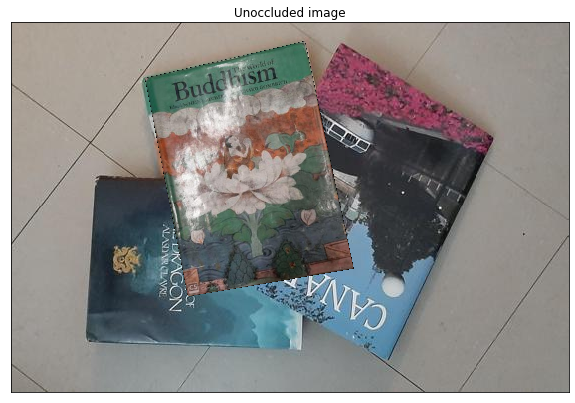

In [7]:
#replace only color pixels from the transformed reference image on the occluded image
for i in range(wimg.shape[0]):
    for k in range(wimg.shape[1]):
        for l in range(wimg.shape[2]):
            if(np.all(wimg[i,k,l] != 0)):
                img_occ[i,k,l] = wimg[i,k,l] 

plt.figure(figsize=(10,10))
plt.imshow(img_occ)
plt.title("Unoccluded image"), plt.xticks([]), plt.yticks([])
plt.show()